In [1]:
from typing import Any, Optional, Dict, Iterable
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import patheffects
import matplotlib.pyplot as plt
import joblib
from adjustText import adjust_text


sns.set_theme(
    style="ticks",
    font_scale=1.5,
    rc={ 
        "figure.figsize": (15, 8), 
        "font.size": 14,
    }
)

COLORS = (
    "#EB7159", 
    "#66C8E6", 
    "#AB65B5", 
    "#829F49",
    "#6876CE",
    "#BE8A3B",
    "#CF5786",
    "#AD483A"
) 

HERE = Path(".").absolute()
ROOT = HERE.parent.parent
DATA = HERE/"data"
FIGPATH = ROOT/"figures"/"domains"
FIGPATH.mkdir(exist_ok=True, parents=True)

LINE_STROKE = [
    patheffects.Normal()
]
LINE_PARAMS = dict(
    linewidth=3,
    path_effects=LINE_STROKE
)
FONTS = dict(
    fontsize=20,
    fontweight="bold"
)
FONT_EFFECT = patheffects.withStroke(linewidth=5, foreground="white")

rawdata = joblib.load(DATA/"domains.pkl.gz")

In [2]:
# Check if simulated null distributions for networks
# have at least 100 values per unique node degree
# in the observed network.
for name, dct in rawdata.items():
    if (dct["report"] < 100).any():
        print(name)
        print(dct["report"])

# Introduction

Here we study similarity and complementarity in different social and biological
networks through the lense of structural coefficients. First, we focus on
node-wise coefficients vis-a-vis node degrees and compare observed trends
to their corresponding null model averages. Then, we analyze fractions
of nodes with significantly high values.

Null distributions are simulated based on 100 randomized networks sampled
from Undirected Binary Configuration model (UBCM).

We study the following networks:

1. Zachary Karate Club network (`karate/78`)
1. Interpersonal contacts among windsurfer (`windsurfers`)
1. Friendship between students in a residence hall (`residence_hall`)
1. Combined network of 10 ego-net samples from Facebook (`ego_social/facebook_combined`)
1. Facebook friendships within several organizations (`facebook_organizations`)
1. Network of mentions in the Dutch field of literary criticism (`dutch_criticism`)
1. Trust between physicians in four American cities (`physician_trust`)
1. Trust network from Epinions.com (`epinions_trust`)
1. Trust network among users on Advogato platform (`advogato`)
1. Strongly connected component of Pretty-Good-Privacy (PGP) web of trust (`pgp_strong`)
1. Interactome network for the PDZ-domian proteins (`interactome_pdz`)
1. Joshi-Tope human protein interactome (`reactome`)
1. A network of human proteins and their binding interactions (`interactome_figeys`)
1. A network of human proteins and their binding interactions (`interactome_stelzl`)
1. A network of human proteins and their binding interactions (`interactome_vidal`)
1. Network of protein-protein interactions in Saccharomyces cerevisiae (`interactome_collins`)
1. A network of protein-protein binding interactions among yeast proteins (`interactome_yeast`)
1. Gene transcription factor-based regulation, within the bacteria E. coli (`ecoli_transcription`)
1. Gene transcription factor-based regulation, within the yeast (`yeast_transcription`)

## Structural coefficients and node degrees

In [3]:
## Structural coefficients spectrum data
sdf = pd.concat([
    v["data"] for v in rawdata.values()
]).drop(columns="di")

In [4]:
def plot_spectrum(
    data: pd.DataFrame,
    ax: mpl.axes.Axes,
    *,
    colors: Iterable[str] = COLORS[:2],
    coefs: Iterable[str] = ("sim", "comp"),
    ci: float = .95,
    plot_kws: Optional[Dict] = None,
    scatter_kws: Optional[Dict] = None,
    ci_kws: Optional[Dict] = None,
    logx: bool = True,
    logy: bool = False
) -> None:
    """Plot structural coefficients spectrum for a given network.
    
    Parameters
    ----------
    data
        Data frame with observed and null model data
        grouped in node degree bins.
    ax
        Axes to use for plotting.
    """
    assert len(coefs) == len(colors),\
    "'coefs' and 'colors' must have the same length"

    alpha = 1 - ci
    cols  = [ "dbin", *coefs ]

    odf = data.loc[data["which"] == "observed", cols]
    ndf = data.loc[data["which"] == "randomized", cols] 
    
    mean = ndf.groupby("dbin").mean().reset_index()
    low  = ndf.groupby("dbin").quantile(alpha/2).reset_index()
    high = ndf.groupby("dbin").quantile(1 - alpha/2).reset_index()

    plot_kws    = { **LINE_PARAMS, **(plot_kws or {}) }
    scatter_kws = { "edgecolors": "white", "zorder": 100, **(scatter_kws or {}) }
    ci_kws      = ci_kws or {}

    # Plot observed trend
    for coef, color in zip(coefs, colors):
        # plot line
        args = (odf["dbin"], odf[coef])
        kws  = { "color": color, "ls": "-", **plot_kws }
        ax.plot(*args, **kws)
        # plot markers
        kws = { "color": color, "marker": "o", "s": 150, **scatter_kws }
        ax.scatter(*args, **kws)
    
    # Plot null model trend
    for coef, color in zip(coefs, colors):
        # plot line
        args = (mean["dbin"], mean[coef])
        kws  = { "color": color, "ls": "--", **plot_kws }
        ax.plot(*args, **kws)
        # plot CI
        args = (mean["dbin"], low[coef], high[coef])
        kws = { "color": color, "alpha": .2, **ci_kws }
        ax.fill_between(*args, **kws)

        label = data["label"].iloc[0]
        ax.set_title(label, **FONTS)

    # Customize aethetics
    ax.tick_params(axis="both", which="major", labelsize=12)
    ax.tick_params(axis="both", which="minor", labelsize=12)
    formatter = mpl.ticker.FormatStrFormatter("%.2f")
    ax.yaxis.set_major_formatter(formatter)
    # Transform axes
    if logx:
        ax.set_xscale("log", base=2)
    if logy:
        ax.set_yscale("log", base=2)


def get_legend_spec(
    lw: int = 6,
    *,
    colors: Iterable[str] = COLORS[:2],
    labels: Iterable[str] = (r"$s_i$", r"$c_i$")
) -> Iterable:
    """Get legend specification for the plot.
    
    Parameters
    ----------
    lw
        Line width.
    """
    assert len(colors) == len(labels),\
        "'colors' and 'labels' must have the same length"
    lines = [
        mpl.lines.Line2D([0], [0], color=color, lw=lw)
        for color in colors 
    ]
    return lines, list(labels)

def get_legend_box_params(**kwds: Any) -> Dict:
    """Get legend box param dictionary."""
    return {
        "fontsize": 18,
        "edgecolor": "black",
        "facecolor": "#F4F4F4",
        **kwds
    }

### Social networks

#### Friendship (offline)

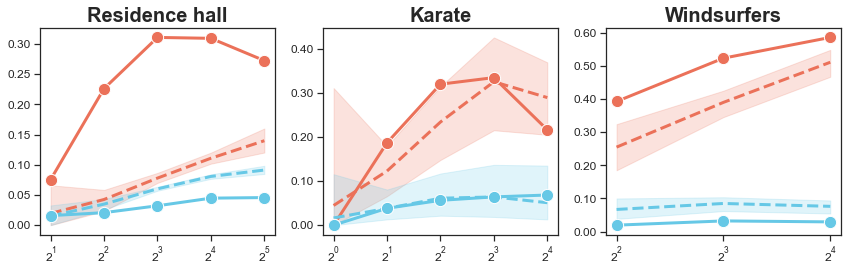

In [5]:
mask = (sdf["domain"] == "social") \
    & (sdf["relation"] == "friendship") \
    & (sdf["desc"] == "offline")

data   = sdf[mask]
labels = data["label"].unique()
ncols  = len(labels)

fig, axes = plt.subplots(ncols=ncols, figsize=(12, 4))

for label, ax in zip(labels, axes):
    df = data[data["label"] == label]
    plot_spectrum(df, ax=ax)

fig.tight_layout()

#### Friendship (online/ego-networks)

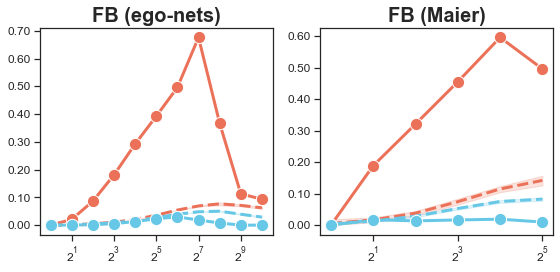

In [6]:
mask = (sdf["domain"] == "social") \
    & (sdf["relation"] == "friendship") \
    & (sdf["desc"] == "online") \
    & (sdf["label"].isin(["FB (ego-nets)", "FB (Maier)"]))

data   = sdf[mask]
labels = data["label"].unique()
ncols  = len(labels)

fig, axes = plt.subplots(ncols=ncols, figsize=(8, 4))

for label, ax in zip(labels, axes):
    df = data[data["label"] == label]
    plot_spectrum(df, ax=ax)

fig.tight_layout()

#### Friendship (online/organization)

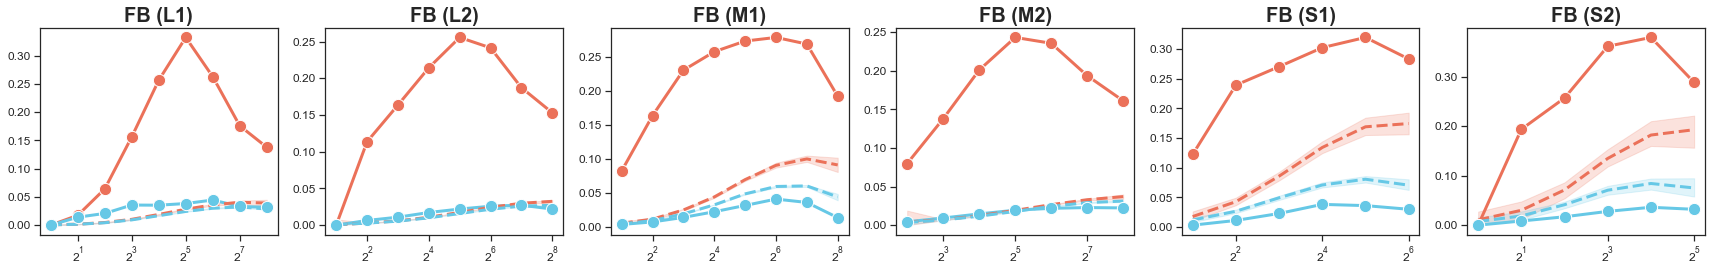

In [7]:
mask = (sdf["domain"] == "social") \
    & (sdf["relation"] == "friendship") \
    & (sdf["desc"] == "online") \
    & (~sdf["label"].isin(["FB (ego-nets)", "FB (Maier)"]))

data   = sdf[mask]
labels = np.sort(data["label"].unique())
ncols  = len(labels)

fig, axes = plt.subplots(ncols=ncols, figsize=(24, 4))

for label, ax in zip(labels, axes):
    df = data[data["label"] == label]
    plot_spectrum(df, ax=ax)

fig.tight_layout()

#### Trust (offline)

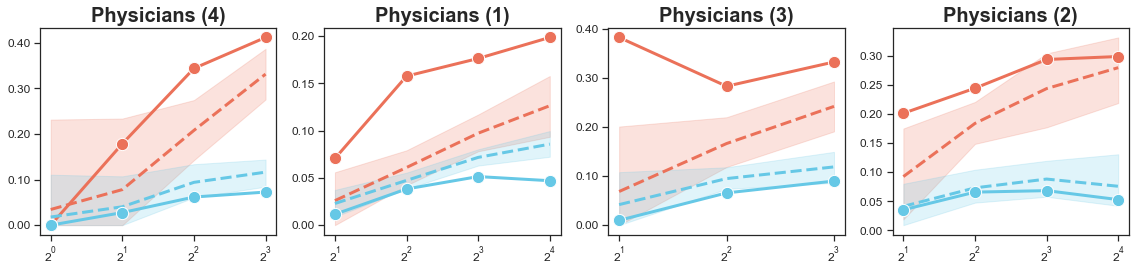

In [8]:
mask = (sdf["domain"] == "social") \
    & (sdf["relation"] == "trust") \
    & (sdf["desc"] == "offline")

data   = sdf[mask]
labels = data["label"].unique()
ncols  = len(labels)

fig, axes = plt.subplots(ncols=ncols, figsize=(16, 4))

for label, ax in zip(labels, axes):
    df = data[data["label"] == label]
    plot_spectrum(df, ax=ax)

fig.tight_layout()

#### Trust (online)

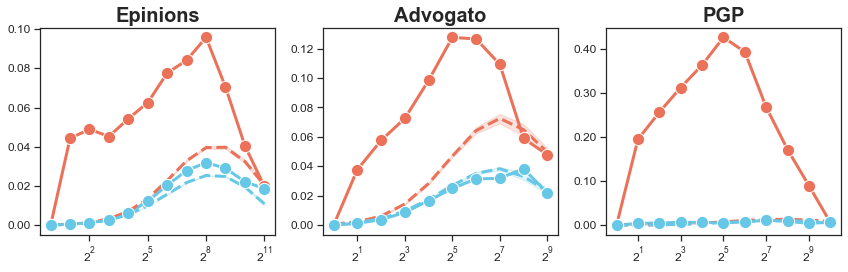

In [9]:
mask = (sdf["domain"] == "social") \
    & (sdf["relation"] == "trust") \
    & (sdf["desc"] == "online")

data   = sdf[mask]
labels = data["label"].unique()
ncols  = len(labels)

fig, axes = plt.subplots(ncols=ncols, figsize=(12, 4))

for label, ax in zip(labels, axes):
    df = data[data["label"] == label]
    plot_spectrum(df, ax=ax)

fig.tight_layout()

#### Recognition

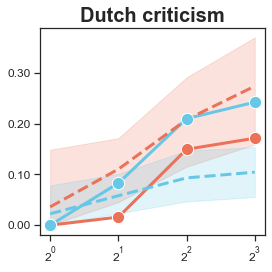

In [10]:
mask = (sdf["domain"] == "social") \
    & (sdf["relation"] == "recognition") \
    & (sdf["desc"] == "offline")

data   = sdf[mask]
labels = data["label"].unique()
ncols  = len(labels)

fig, axes = plt.subplots(ncols=ncols, figsize=(4, 4))

if not isinstance(axes, np.ndarray):
    axes = [axes]

for label, ax in zip(labels, axes):
    df = data[data["label"] == label]
    plot_spectrum(df, ax=ax)

fig.tight_layout()

### Biological networks

#### Protein-protein interactions (humans)

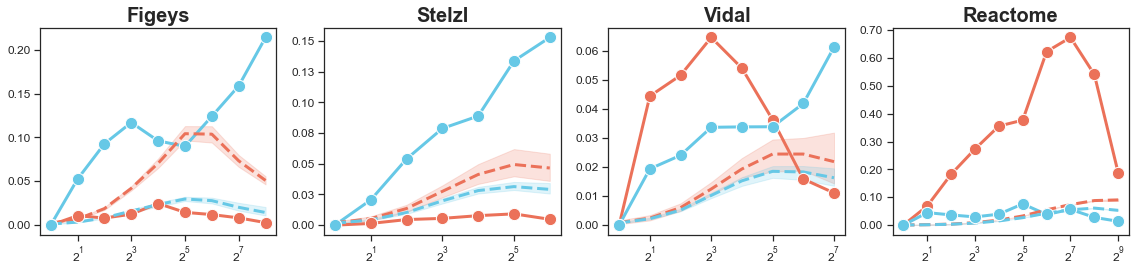

In [11]:
mask = (sdf["domain"] == "biological") \
    & (sdf["relation"] == "interactome") \
    & (sdf["desc"] == "human")

data   = sdf[mask]
labels = data["label"].unique()
ncols  = len(labels)

fig, axes = plt.subplots(ncols=ncols, figsize=(16, 4))

if not isinstance(axes, np.ndarray):
    axes = [axes]

for label, ax in zip(labels, axes):
    df = data[data["label"] == label]
    plot_spectrum(df, ax=ax)

fig.tight_layout()

#### Protein-protein interactions (yeast)

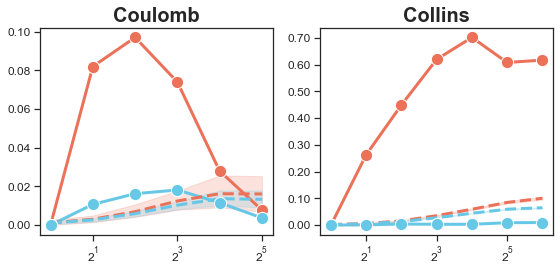

In [12]:
mask = (sdf["domain"] == "biological") \
    & (sdf["relation"] == "interactome") \
    & (sdf["desc"] == "yeast")

data   = sdf[mask]
labels = data["label"].unique()
ncols  = len(labels)

fig, axes = plt.subplots(ncols=ncols, figsize=(8, 4))

if not isinstance(axes, np.ndarray):
    axes = [axes]

for label, ax in zip(labels, axes):
    df = data[data["label"] == label]
    plot_spectrum(df, ax=ax)

fig.tight_layout()

#### Protein-protein interactions (PDZ domain)

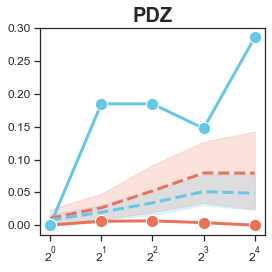

In [13]:
mask = (sdf["domain"] == "biological") \
    & (sdf["relation"] == "interactome") \
    & (sdf["desc"] == "PDZ")

data   = sdf[mask]
labels = data["label"].unique()
ncols  = len(labels)

fig, axes = plt.subplots(ncols=ncols, figsize=(4, 4))

if not isinstance(axes, np.ndarray):
    axes = [axes]

for label, ax in zip(labels, axes):
    df = data[data["label"] == label]
    plot_spectrum(df, ax=ax)

fig.tight_layout()

#### Gene regulation

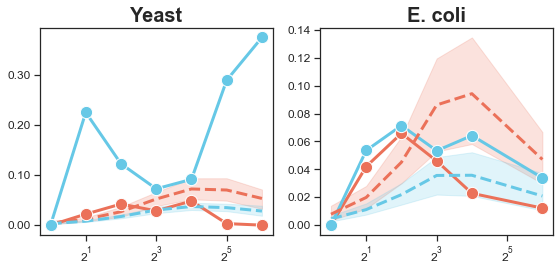

In [14]:
mask = (sdf["domain"] == "biological") \
    & (sdf["relation"] == "genetic")

data   = sdf[mask]
labels = data["label"].unique()
ncols  = len(labels)

fig, axes = plt.subplots(ncols=ncols, figsize=(8, 4))

if not isinstance(axes, np.ndarray):
    axes = [axes]

for label, ax in zip(labels, axes):
    df = data[data["label"] == label]
    plot_spectrum(df, ax=ax)

fig.tight_layout()

# Main plots

## Average calibrated node-wise coefficients

In [21]:
pdf = pd.concat([
    v["sig"] for v in rawdata.values()
]) 
cdf = pd.concat([
    v["cdata"] for v in rawdata.values()
]).merge(pdf[["name"]], how="left", on="name")


def get_node_sizes(x): 
    return 200 + 8*np.sqrt(x)

### Social networks

/tmp/ipykernel_55749/868359285.py:62: MatplotlibDeprecationWarning: Passing argument *p* of unexpected type Line2D to add_patch which only accepts <class 'matplotlib.patches.Patch'> is deprecated since 3.5 and will become an error two minor releases later.
  lax.add_patch(marker)
/tmp/ipykernel_55749/868359285.py:85: MatplotlibDeprecationWarning: Passing argument *p* of unexpected type Line2D to add_patch which only accepts <class 'matplotlib.patches.Patch'> is deprecated since 3.5 and will become an error two minor releases later.
  lax.add_patch(marker)
/tmp/ipykernel_55749/868359285.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


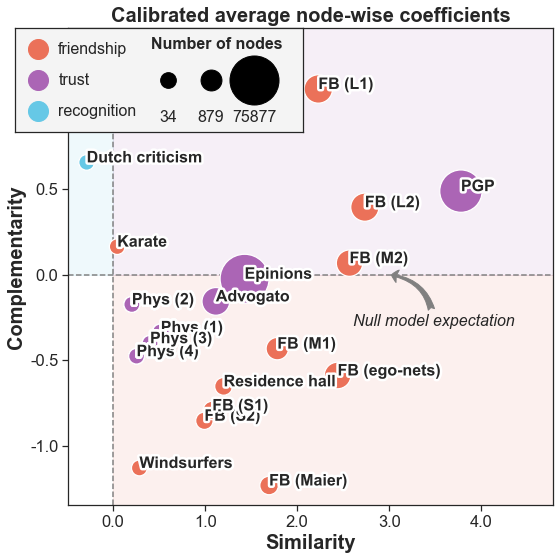

In [22]:
x, y    = ["sim", "comp"]
data    = cdf[cdf["domain"] == "social"]
palette = {
    "friendship":  COLORS[0],
    "trust":       COLORS[2],
    "recognition": COLORS[1],
}

fig, ax = plt.subplots(figsize=(8, 8))

scatter = sns.scatterplot(
    x=x, y=y, hue="relation", data=data, ax=ax,
    s=get_node_sizes(data["n_nodes"]), 
    palette=palette, hue_order=list(palette)
)
ax.get_legend().remove()

x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()

ax.set_xlim(x0, x1*1.2)
ax.set_ylim(y0, y1*1.2)

# Non-random fraction line
kwds  = dict(xycoords="data", fontweight="roman", fontstyle="italic", fontsize=16)
aprop = dict(arrowstyle="fancy,head_width=0.8", color="black")
ax.axhline(0, ls="--", color="gray", zorder=-1)
ax.axvline(0, ls="--", color="gray", zorder=-1)
ax.annotate(
    "Null model expectation", xy=(3, 0), xytext=(2.6, -.3),
    arrowprops={**aprop, "connectionstyle": "arc3,rad=.4", "color": "gray"},
    **kwds
)

texts = []
for x, y, text, n in zip(data[x], data[y], data["label"], data["n_nodes"]):
    if text.startswith("Physician"):
        text = f"Phys {text.split()[-1]}"
    text = ax.text(x, y, text, fontweight="bold", fontsize=16)
    text.set_path_effects([ FONT_EFFECT ])
    texts.append(text)

# Custom legend 
lax = fig.add_axes(
    [.04, .757, .5, .18],
    transform=ax.transAxes
)
lax.get_xaxis().set_ticks([])
lax.get_yaxis().set_ticks([])
lax.set_facecolor(get_legend_box_params()["facecolor"])
# Relations
xmarker   = .08
ytop      = .8
for i, param in enumerate(palette.items()):
    rel, color = param
    y = ytop - .3*i
    size = np.sqrt(400)
    marker = mpl.lines.Line2D(
        [xmarker], [y], linestyle="None",
        color=color, marker="o", markersize=size
    )
    lax.add_patch(marker)
    lax.annotate(
        rel, (xmarker+.07, y),
        va="center", fontsize=16
    )
# Number of nodes
xtitle  = .7
xstart  = .53
n_nodes = data["n_nodes"].quantile([0, .75, 1]).astype(int).values
sizes   = np.sqrt(get_node_sizes(n_nodes))

lax.annotate(
    "Number of nodes", (xtitle, ytop),
    ha="center", fontsize=16, weight="bold"
)
for i, param in enumerate(zip(n_nodes, sizes)):
    n, size = param
    x = xstart + i*.15
    y = ytop - .3
    marker = mpl.lines.Line2D(
        [x], [y], linestyle="None", 
        color="black", marker="o", markersize=size
    )
    lax.add_patch(marker)
    lax.annotate(
        str(n), (x, y - .4),
        ha="center", fontsize=16
    )

ax.fill_between([0, 5], [0, 0], [-2, -2], color=COLORS[0], alpha=.1, zorder=-2)
ax.fill_between([-1, 0], [0, 0], [2, 2], color=COLORS[1], alpha=.1, zorder=-2)
ax.fill_between([0, 5], [0, 0], [2, 2], color=COLORS[2], alpha=.1, zorder=-2)

ax.set_xlabel("Similarity", **FONTS)
ax.set_ylabel("Complementarity", **FONTS)
ax.set_title("Calibrated average node-wise coefficients", y=1.0, **FONTS)

formatter = mpl.ticker.FormatStrFormatter("%.1f")
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

fig.tight_layout()
fig.savefig(FIGPATH/"nodes-social.pdf", bbox_inches="tight")

### Biological networks

/tmp/ipykernel_55749/4069629855.py:75: MatplotlibDeprecationWarning: Passing argument *p* of unexpected type Line2D to add_patch which only accepts <class 'matplotlib.patches.Patch'> is deprecated since 3.5 and will become an error two minor releases later.
  lax.add_patch(marker)
/tmp/ipykernel_55749/4069629855.py:98: MatplotlibDeprecationWarning: Passing argument *p* of unexpected type Line2D to add_patch which only accepts <class 'matplotlib.patches.Patch'> is deprecated since 3.5 and will become an error two minor releases later.
  lax.add_patch(marker)
/tmp/ipykernel_55749/4069629855.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


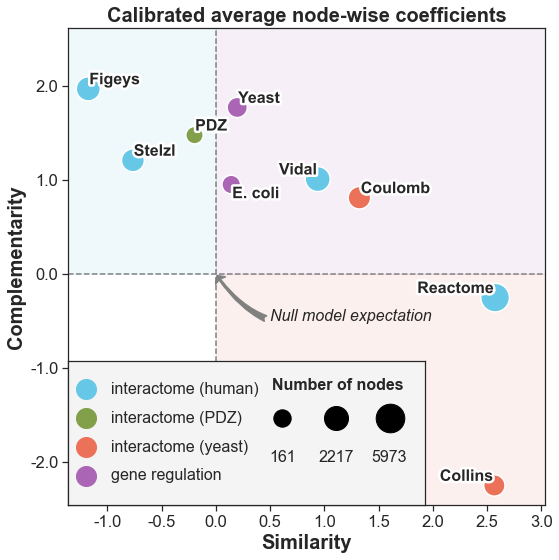

In [23]:
data = cdf[cdf["domain"] == "biological"].copy()
data["relation"] = np.where(
    data["relation"] == "interactome",
    data["relation"] + " (" + data["desc"] + ")",
    data["relation"]
)

palette = {
    "interactome (human)": COLORS[1],
    "interactome (PDZ)":   COLORS[3],
    "interactome (yeast)": COLORS[0],
    "genetic":             COLORS[2],
}
df = data.set_index("relation")[["sim", "comp"]] \
    .pipe(np.exp) \
    .reset_index("relation")

fig, ax = plt.subplots(figsize=(8, 8))

scatter = sns.scatterplot(
    x="sim", y="comp", hue="relation", data=data, ax=ax,
    s=get_node_sizes(data["n_nodes"]), 
    palette=palette, hue_order=list(palette)
)
ax.get_legend().remove()

x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()

ax.set_xlim(x0, x1*1.1)
ax.set_ylim(y0, y1*1.2)

# Non-random fraction line
kwds  = dict(xycoords="data", fontweight="roman", fontstyle="italic", fontsize=16)
aprop = dict(arrowstyle="fancy,head_width=0.8", color="black")
ax.axhline(0, ls="--", color="gray", zorder=-1)
ax.axvline(0, ls="--", color="gray", zorder=-1)
ax.annotate(
    "Null model expectation", xy=(0, 0), xytext=(0.5, -.5),
    arrowprops={**aprop, "connectionstyle": "arc3,rad=-.4", "color": "gray"},
    **kwds
)

texts = []
for x, y, text, n in zip(data["sim"], data["comp"], data["label"], data["n_nodes"]):
    if text.startswith("Physician"):
        text = f"Phys {text.split()[-1]}"
    text = ax.text(x, y, text, fontweight="bold", fontsize=16)
    text.set_path_effects([ FONT_EFFECT ])
    texts.append(text)

adjust_text(texts)

# Custom legend 
lax = fig.add_axes(
    [.132, .11, .62, .25],
    transform=ax.transAxes
)
lax.get_xaxis().set_ticks([])
lax.get_yaxis().set_ticks([])
lax.set_facecolor(get_legend_box_params()["facecolor"])
# Relations
xmarker   = .05
ytop      = .8
for i, param in enumerate(palette.items()):
    rel, color = param
    if rel == "genetic":
        rel = "gene regulation"
    y = ytop - .2*i
    size = np.sqrt(400)
    marker = mpl.lines.Line2D(
        [xmarker], [y], linestyle="None",
        color=color, marker="o", markersize=size
    )
    lax.add_patch(marker)
    lax.annotate(
        rel, (xmarker+.07, y),
        va="center", fontsize=16
    )
# # Number of nodes
xtitle  = .755
xstart  = .6
n_nodes = data["n_nodes"].quantile([0, .75, 1]).astype(int).values
sizes   = np.sqrt(get_node_sizes(n_nodes))

lax.annotate(
    "Number of nodes", (xtitle, ytop),
    ha="center", fontsize=16, weight="bold"
)
for i, param in enumerate(zip(n_nodes, sizes)):
    n, size = param
    x = xstart + i*.15
    y = ytop - .2
    marker = mpl.lines.Line2D(
        [x], [y], linestyle="None", 
        color="black", marker="o", markersize=size
    )
    lax.add_patch(marker)
    lax.annotate(
        str(n), (x, y - .3),
        ha="center", fontsize=16
    )

ax.fill_between([0, 5], [0, 0], [-3, -3], color=COLORS[0], alpha=.1, zorder=-2)
ax.fill_between([-2, 0], [0, 0], [3, 3], color=COLORS[1], alpha=.1, zorder=-2)
ax.fill_between([0, 5], [0, 0], [3, 3], color=COLORS[2], alpha=.1, zorder=-2)

formatter = mpl.ticker.FormatStrFormatter("%.1f")
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

ax.set_xlabel("Similarity", **FONTS)
ax.set_ylabel("Complementarity", **FONTS)
ax.set_title("Calibrated average node-wise coefficients", y=1.0, **FONTS)
fig.tight_layout()
fig.savefig(FIGPATH/"nodes-biological.pdf", bbox_inches="tight")

# Supplementary Information: degree correlations in configuration model

Here we present degree correlations for all similarity
($s^W_i, s^H_i, s_i$) and complementarity ($c^W_i, c^H_i, c_i$) coefficients
in randomized ensembles induced by all the empirical networks studied above.

In [24]:
keys = ["domain", "relation", "label"]

data = sdf[sdf["which"] == "randomized"] \
    .groupby([*keys, "dbin"]) \
    .mean() \
    .reset_index()

sequence = data.groupby(keys) \
    .size() \
    .index \
    .to_frame() \
    .reset_index(drop=True) \
    .sort_values(["domain", "relation"], ascending=[False, True]) \
    .reset_index(drop=True)

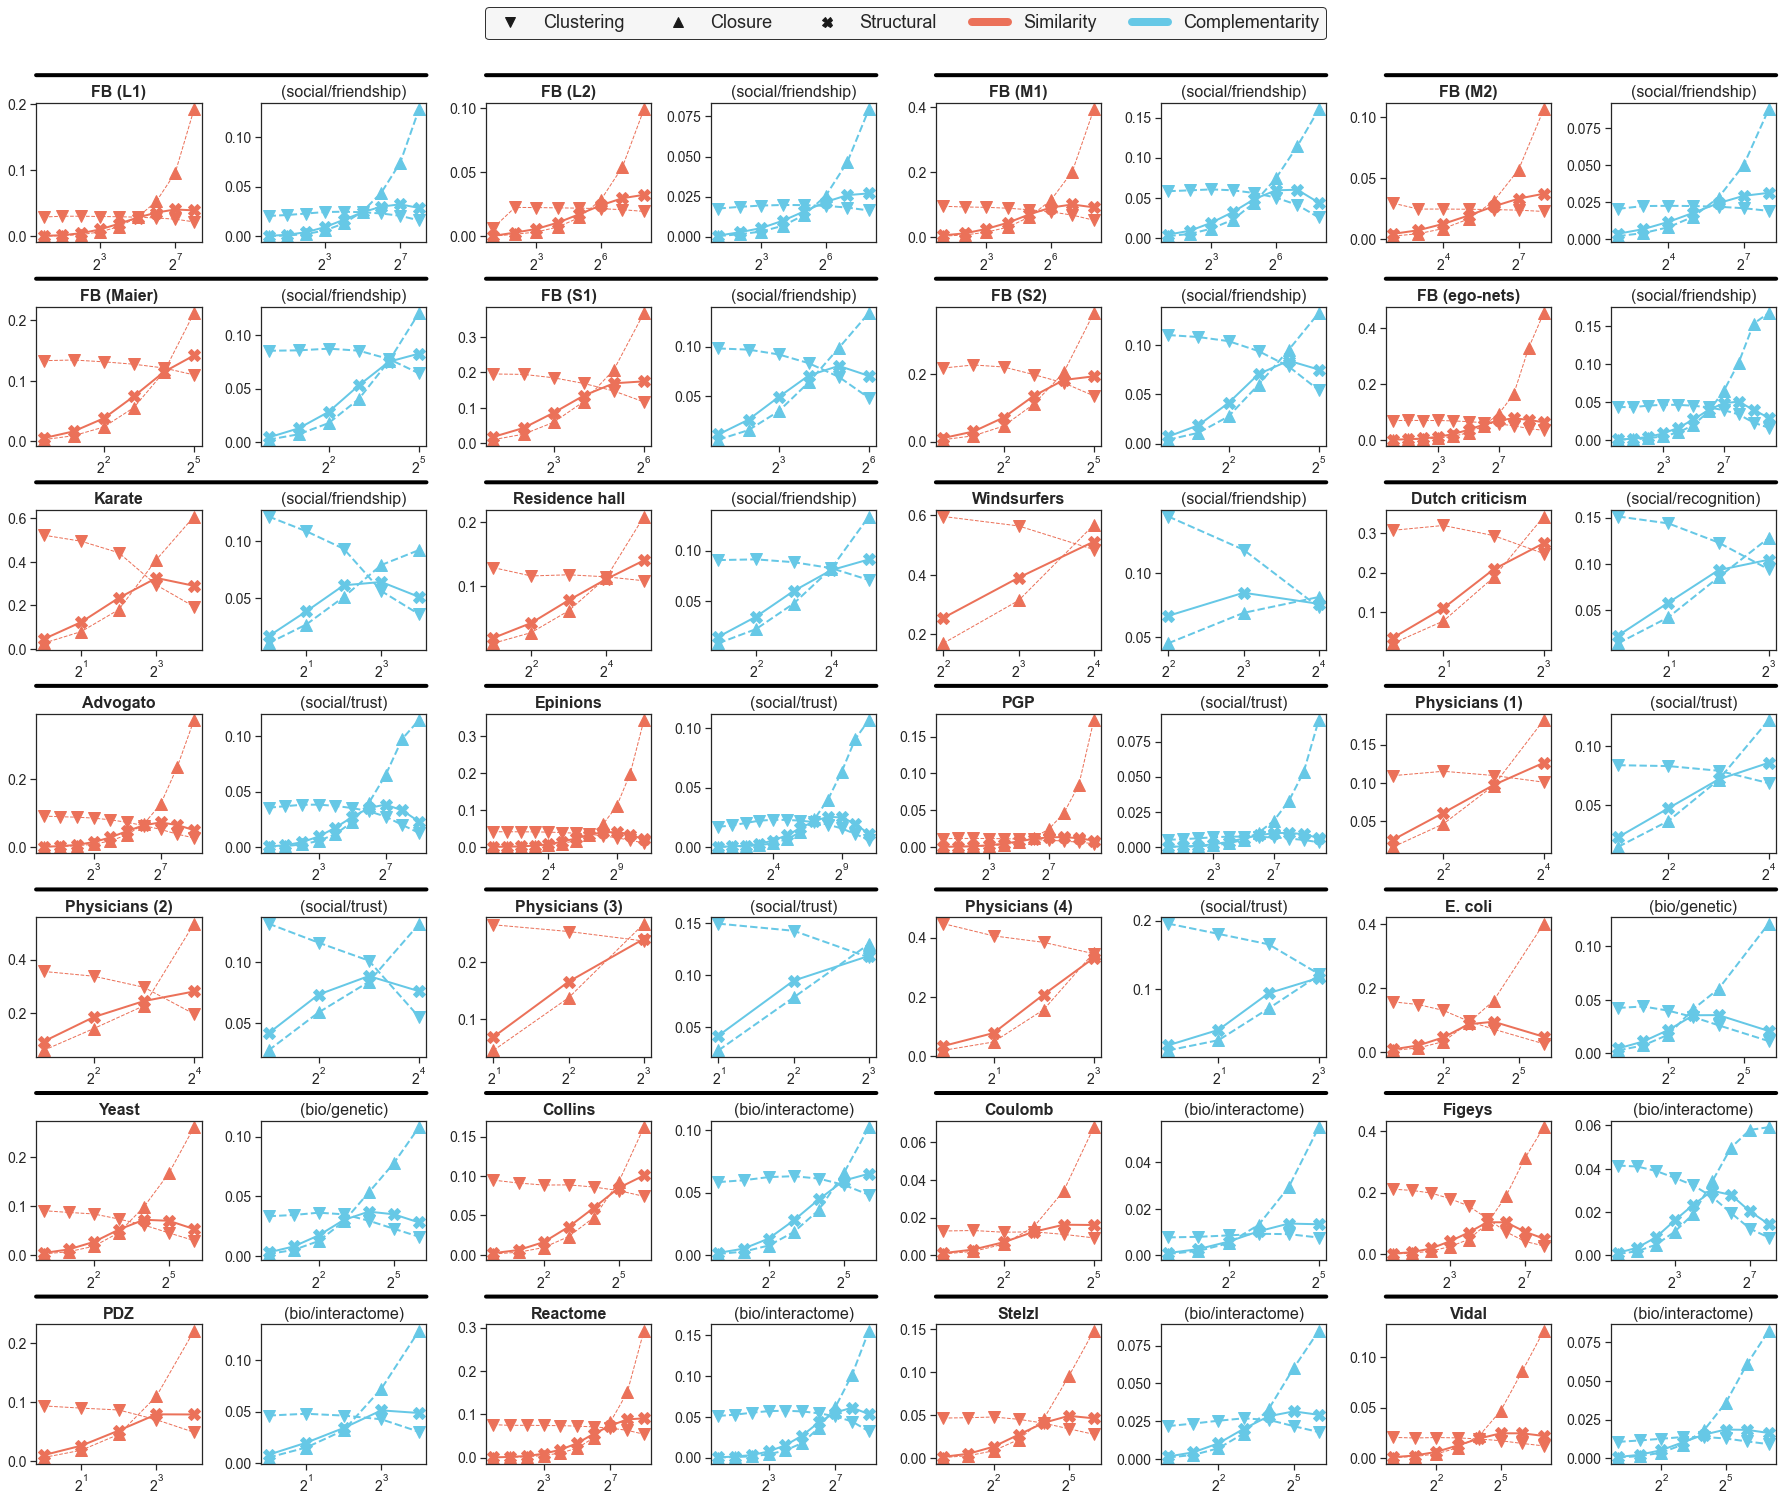

In [25]:
simcols  = ["tclust", "tclosure", "sim"]
compcols = ["qclust", "qclosure", "comp"]
lstyles  = ["--", "--", "-"]
lwidths  = [1, 1, 2]
markers  = ["v", "^", "X"]
socrels  = ["friendship", "trust", "recognition"]
biorels  = ["genetic", "interactome"]
palette  = zip([*socrels, *biorels], COLORS)

fig, axes = plt.subplots(7, 8, figsize=(25, 20))
axes = axes.reshape(-1, 2)

for meta, row in zip(sequence.values, axes):
    ax1, ax2 = row
    dom, rel, lab = meta

    if dom == "biological":
        dom = "bio"

    df   = data[data["label"] == lab]
    x    = df["dbin"]
    kwds = dict(markersize=12) 
    # Plot similarity coefficients
    for col, mark, ls, lw in zip(simcols, markers, lstyles, lwidths):
        ax1.plot(x, df[col], color=COLORS[0], marker=mark, ls=ls, lw=lw, **kwds)
    # Plot complementarity coefficients
    for col, ls, mark in zip(compcols, lstyles, markers):
        ax2.plot(x, df[col], color=COLORS[1], marker=mark, ls=ls, lw=lw, **kwds)
    
    # Set descriptions
    fontsize = 16
    ax1.set_title(lab, fontsize=fontsize, fontweight="bold")
    ax2.set_title(f"({dom}/{rel})", fontsize=fontsize)
    
    for ax in (ax1, ax2):
        ax.set_xscale("log", base=2)
        ax.tick_params(axis="both", which="major", labelsize=14)
        ax.tick_params(axis="both", which="minor", labelsize=12)
    
    # Add joint label
    con = mpl.patches.ConnectionPatch(
        xyA=(0, 1.2), coordsA=ax1.transAxes,
        xyB=(1, 1.2), coordsB=ax2.transAxes
    )
    con.set_color("black")
    con.set_linewidth(4)
    ax2.add_artist(con)

# Add legend
xy    = ([0], [0])
lkwds = get_legend_box_params()
lines = [
    mpl.lines.Line2D(*xy, color=COLORS[0], lw=8),
    mpl.lines.Line2D(*xy, color=COLORS[1], lw=8)
]
mkwds = dict(linestyle="none", color="k", markersize=10)
marks = [
    mpl.lines.Line2D(*xy, marker="v", **mkwds),
    mpl.lines.Line2D(*xy, marker="^", **mkwds),
    mpl.lines.Line2D(*xy, marker="X", **mkwds),
]
labels = [
    "Clustering", "Closure", "Structural",
    "Similarity", "Complementarity"
]
fig.legend(
    [*marks, *lines], labels, 
    ncol=len(labels), loc="upper center",
    bbox_to_anchor=(.5075, 1.05),
    **lkwds
)

fig.tight_layout()
fig.savefig(FIGPATH/"SI-degree-correlations.pdf", bbox_inches="tight")